In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

file = "293K_SectionA.xlsx"
sheets = ["Wide_Spectra", "Peak_Spectra"]
cols = [["WS_0", "WS_1", "WS_2", "WS_3", "WS_4", "WS_5", "WS_6", "WS_7", "WS_8", "WS_9"],  #Wide_spectra
        ["PS_0", "PS_1", "PS_2", "PS_3", "PS_4", "PS_5", "PS_6", "PS_7", "PS_8", "PS_9"]  #Peak_Spectra
        ]
start_index = [9830, 9795]

In [12]:
def wavelength_extraction(x, start_index):
    A = 1.0095
    alpha_A = 0.0001

    B = 9091.0570
    alpha_B = 0.0289

    wavelengths = []
    uncertainties = []

    for i in range(len(x)):
        wavelength = (start_index - x[i] / 10 - B) / A
        uncertainty = np.abs((x[i] - (B + alpha_B)) / (A + alpha_A) - wavelength)

        wavelengths.append(wavelength)
        uncertainties.append(uncertainty)

    return wavelengths, uncertainties

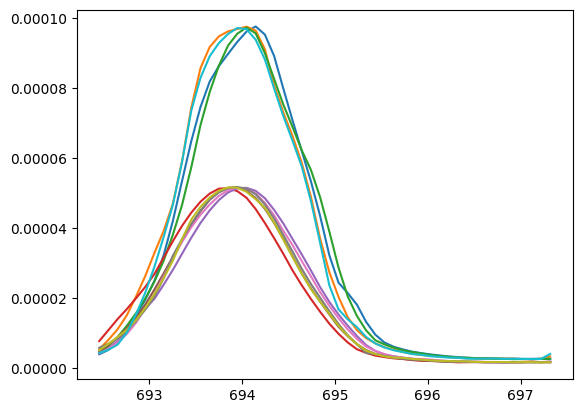

In [46]:
df_PS = pd.read_excel(file, sheet_name=sheets[1])

indexes_50 = np.arange(0,50,1)

wavelengths_50, uncertainties_50 = wavelength_extraction(indexes_50,9795)

for col in cols[1]:
    plt.figure(1)
    plt.plot(wavelengths_50,df_PS[col],label=col)
plt.show()

In [53]:
def lorentzian_function(x, A, x0, B, C):
    B = np.abs(B)
    return A / (1 + ((x - x0)/B)**2) + C

#Other Functions
def chi2_function(model, model_params, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params)) / y_error)**2)

def rchi2_function(model, model_params, x_data, y_data, y_error, DoF):
    return np.sum(((y_data - model(x_data, *model_params)) / y_error)**2)/DoF

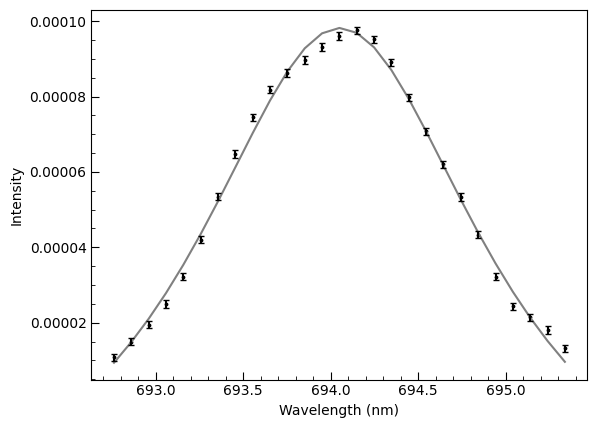

 ----- Results -----
x0: 694.0519634746374
Reduced Chi-Squared: 85.13156415007761
Fitted B: -1.0143051115249662
----- ----- -----


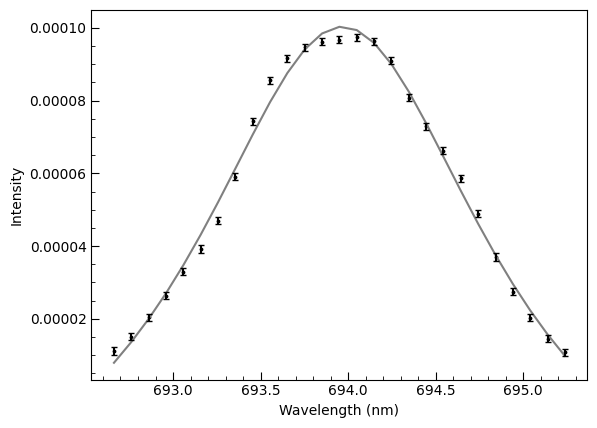

 ----- Results -----
x0: 693.9674883121293
Reduced Chi-Squared: 75.52527832919891
Fitted B: -1.0324344107769678
----- ----- -----


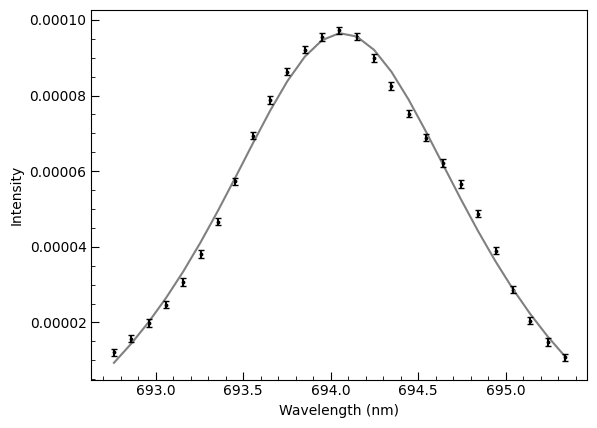

 ----- Results -----
x0: 694.0669983590143
Reduced Chi-Squared: 56.35802250883479
Fitted B: 0.9814768118952845
----- ----- -----


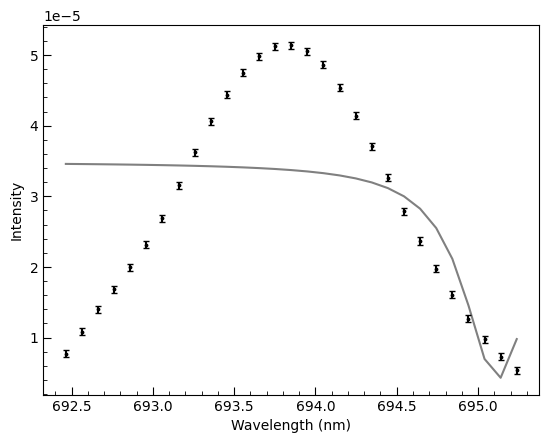

 ----- Results -----
x0: 695.119773547688
Reduced Chi-Squared: 9197.672015464776
Fitted B: -0.24917240852376882
----- ----- -----


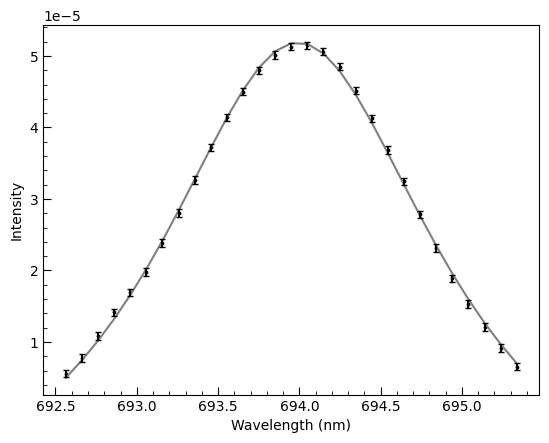

 ----- Results -----
x0: 693.9915251568405
Reduced Chi-Squared: 14.764801491582638
Fitted B: -1.0654558802315028
----- ----- -----


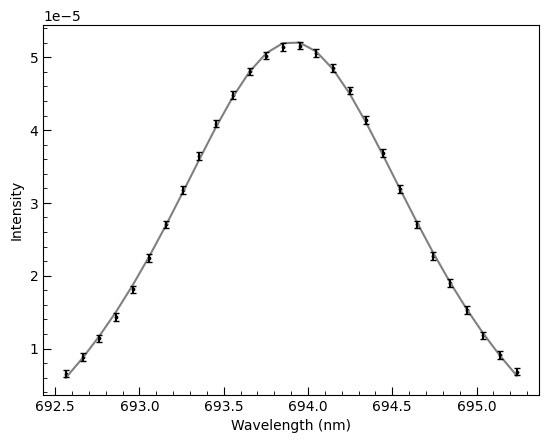

 ----- Results -----
x0: 693.9065251163389
Reduced Chi-Squared: 8.800261671144158
Fitted B: 1.0404467971766311
----- ----- -----


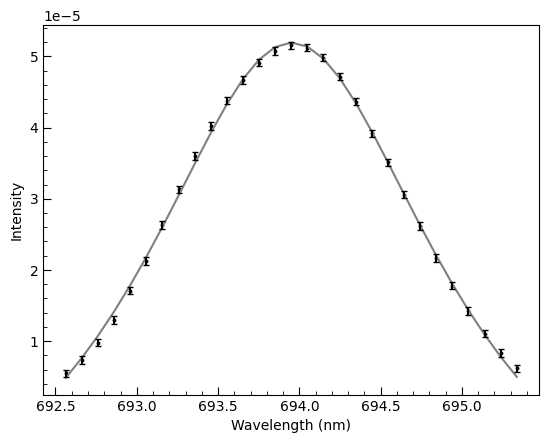

 ----- Results -----
x0: 693.9528939419533
Reduced Chi-Squared: 32.48102580182568
Fitted B: -1.1313622369046072
----- ----- -----


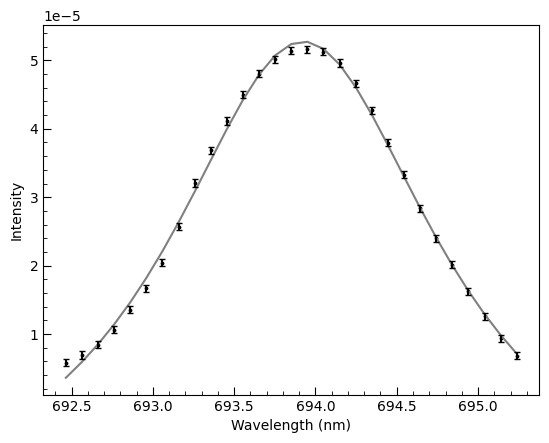

 ----- Results -----
x0: 693.9246378190095
Reduced Chi-Squared: 81.83737520607143
Fitted B: -1.01846139169934
----- ----- -----


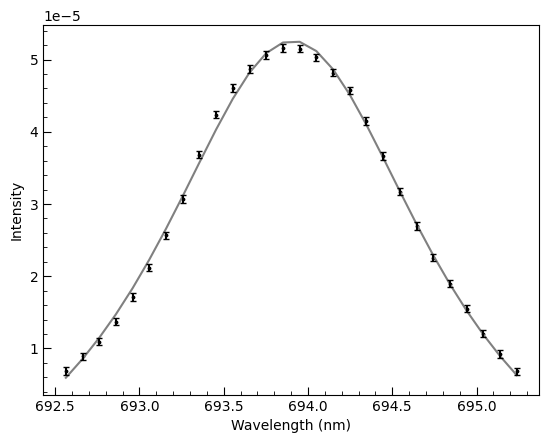

 ----- Results -----
x0: 693.9079995773138
Reduced Chi-Squared: 21.46017667919335
Fitted B: -1.0054763156606865
----- ----- -----


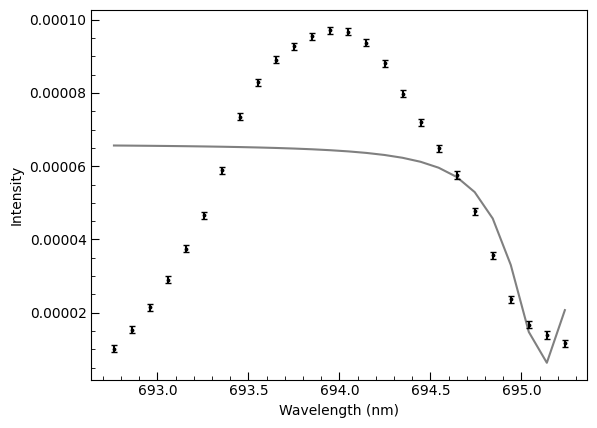

 ----- Results -----
x0: 695.1234318611159
Reduced Chi-Squared: 22365.87003773075
Fitted B: -0.2013882270605681
----- ----- -----
Mean x0: 694.2013 +- 0.1464


In [54]:
x0_list = []

for col in cols[1]:
    ydata = df_PS[col]
    y_fitdata =[]
    wavelengths_50_chosen = []

    cutoff = 0.1
    for i in range(len(ydata)):
        if ydata[i] > cutoff*ydata.max():
            y_fitdata.append(ydata[i])
            wavelengths_50_chosen.append(wavelengths_50[i])

    y_fitdata = np.array(y_fitdata)
    wavelengths_50_chosen = np.array(wavelengths_50_chosen)

    p0_lorentzian = [
        ydata.max(), #A
        693, #x0
        len(y_fitdata)/4, #B
        y_fitdata.min() #C
    ]
    popt, cov = curve_fit(
        lorentzian_function,
        xdata = wavelengths_50_chosen,
        ydata = y_fitdata,
        sigma= y_fitdata.max()/100,
        absolute_sigma=True,
        p0 = p0_lorentzian,
        maxfev= 10000
    )


    dof = len(y_fitdata) - len(popt)
    rchi2 = rchi2_function(lorentzian_function, popt, wavelengths_50_chosen, y_fitdata, y_fitdata/100, dof)

    x0_list.append(popt[1])

    plt.figure(1)
    plt.scatter(wavelengths_50_chosen, y_fitdata, color = "black", s = 3)
    plt.plot(wavelengths_50_chosen, lorentzian_function(wavelengths_50_chosen, *popt), color = "grey")
    plt.errorbar(wavelengths_50_chosen, y_fitdata, y_fitdata.max()/100, linestyle = "none", capsize = 2, color = "black")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")

    plt.minorticks_on()
    plt.tick_params(axis='both', which='major', size=6, direction='in')
    plt.tick_params(axis='both', which='minor', size=3, direction='in')
    plt.show()
    print(f" ----- Results -----")
    print(f"x0: {popt[1]}")
    print(f"Reduced Chi-Squared: {rchi2}")
    print("Fitted B:", popt[2])
    print(f"----- ----- -----")

mean_x0 = np.mean(x0_list)
err_x0 = np.std(x0_list)/np.sqrt(len(x0_list))

print(f"Mean x0: {mean_x0:.4f} +- {err_x0:.4f}")